# K-means Model
- Author: [@vanstrouble](https://github.com/vanstrouble)

K-means is a centroid-based iterative clustering algorithm that divides a dataset into similar groups based on the distance between their centroids. The centroid, or centre of the cluster, is the mean or median of all points within the cluster, depending on the characteristics of the data.

K-means++ is an enhancement of the K-means algorithm that optimizes the selection of initial centroids. Developed by Arthur and Vassilvitskii, K-means++ significantly improves the final clustering quality by reducing the likelihood of the algorithm getting stuck in local minima.

The initialization process in K-means++ begins by randomly selecting the first centroid from the dataset. For each subsequent centroid, the distance of each data point to its nearest already-selected centroid is calculated. The next centroid is then chosen based on a probability distribution that favors points further from their nearest centroid, meaning points that are farther away have a higher chance of being selected. This process continues until the desired number of centroids has been initialized.

|       Pros       |       Cons       |
| ---------------- | ------- |
| Easy to implement | Must manually chose K |
| Always converges to local minimum | Not guaranteed to find global minimum |
| Scales well to large datasets | May not perform well on data of varying density |
| Generalizes to clusters of different shapes and sizes | Clusters are biased by outliers |

In [1]:
import numpy as np
import pandas as pd
import cv2
import warnings
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, load_iris, load_breast_cancer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import silhouette_score

from src.kmeans import Kmeans

warnings.filterwarnings('ignore')

## Display Cluster Function

I have developed the ```display_cluster``` function to illustrate the functionality of the KMeans clustering model, tailored for use within Jupyter Notebook environments.

The ```display_cluster``` function visualizes data distribution through a scatter plot, showcasing clusters produced by a clustering algorithm (such as KMeans) along with their centroids.

This function creates a 2D scatter plot utilizing matplotlib and seaborn for enhanced styling. Data points are color-coded based on their assigned clusters, and cluster centroids are highlighted with a cross marker. The visualization allows for customizable axis labels and a descriptive title, ensuring clarity and flexibility in presenting clustering results.

In [2]:
def display_cluster(X, model=None, num_clusters=0, **kwargs):
    """Show clusters in 2D with Jupyter Notebooks format."""
    sns.set_theme(context="notebook", style="whitegrid")

    # Verify dataset shape
    if X.shape[1] < 2:
        raise ValueError(
            "Dataset X must have at least two features (columns) for 2D visualization"
        )

    # If num_clusters is not specified, use the number of clusters in km
    if model is not None and num_clusters == 0:
        num_clusters = len(model.k)

    # Verify if the number of clusters is valid
    if model is not None and num_clusters > len(model.centroids):
        raise ValueError(
            f"The specified number of clusters ({num_clusters}) is larger than the number of clusters in the model ({len(model.centroids)})"
        )

    # Create color palette based on number of clusters
    if num_clusters > 0:
        palette = sns.color_palette("husl", num_clusters)
    else:
        palette = sns.color_palette("husl", 1)  # Generate at least one color

    alpha = 0.5
    s = 20

    if num_clusters == 0 or model is None:
        plt.scatter(X[:, 0], X[:, 1], color=palette[0], alpha=alpha, s=s)
    else:
        for i, color in enumerate(palette):
            cluster_data = X[model.labels == i]
            plt.scatter(
                cluster_data[:, 0], cluster_data[:, 1], color=color, alpha=alpha, s=s
            )
            plt.scatter(
                model.centroids[i, 0],
                model.centroids[i, 1],
                color="red",
                marker="x",
                s=100,
                edgecolor="black",
            )

    plt.title(kwargs.get("title", f"Cluster Visualization with {num_clusters} cluster/s"))
    plt.xlabel(kwargs.get("feature_x", "Default Feature x"))
    plt.ylabel(kwargs.get("feature_y", "Default Feature y"))
    plt.show()

### Determining optimium number of clusters

Let's create a new dataset that visually consists on a few clusters and try to group them.

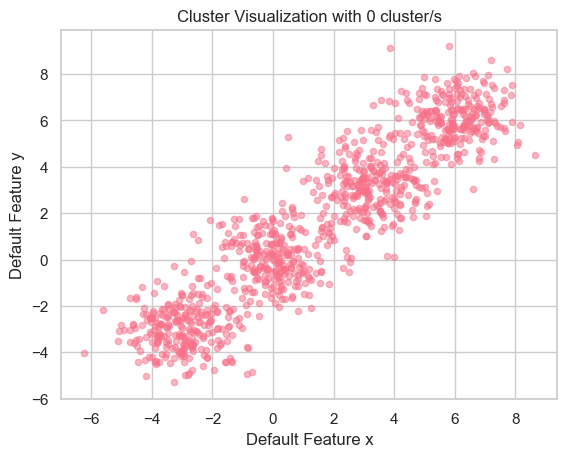

In [3]:
n_samples = 1000
n_bins = 4
centers = [(-3, -3), (0, 0), (3, 3), (6, 6)]
X, y = make_blobs(
    n_samples=n_samples,
    n_features=2,
    cluster_std=1.0,
    centers=centers,
    shuffle=False,
    random_state=42,
)

display_cluster(X)

How many clusters do you observe?

Let's run K-means with seven clusters.

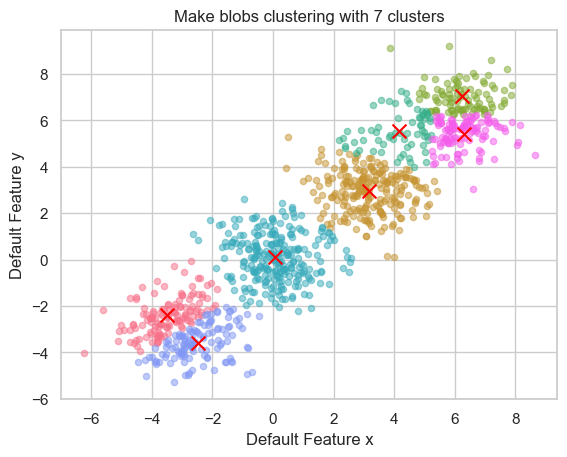

In [4]:
num_clusters = 7
km = Kmeans(k=num_clusters)
labels, centroids = km.predict(X)

display_cluster(X, km, num_clusters, title="Make blobs clustering with 7 clusters")

Now let's re-run the algorithm with four clusters.

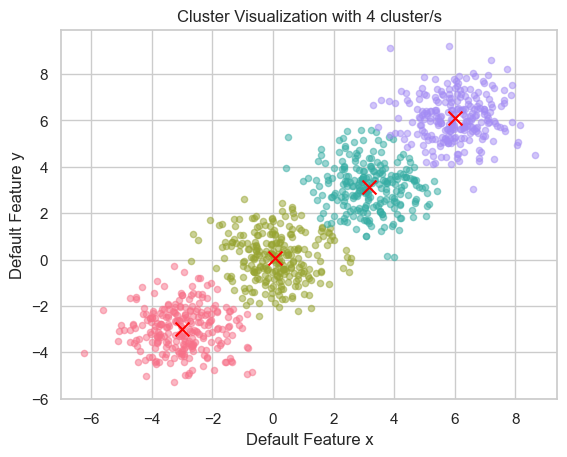

In [5]:
num_clusters = 4
km = Kmeans(k=num_clusters)
labels, centroids = km.predict(X)
display_cluster(X, km, num_clusters)

Should we use four or seven clusters?  

- In this case it may be visually obvious that four clusters is better than seven.  
- This is because we can easily view the data in two dimensional space.  
- However, real world data usually has more than two dimensions.  
- A dataset with a higher dimensional space is hard to visualize.  
- A way of solving this is to plot the **inertia** 

**inertia**: (sum of squared error between each point and its cluster center) as a function of the number of clusters. 

### Elbow Method and Silhouette Score

The elbow method is a popular technique for determining the optimal number of clusters in k-means clustering. It involves plotting the "within-cluster sum of squares" (WCSS) against the number of clusters, k. The WCSS measures the Euclidean distance between each data point and the centroid of its assigned cluster. As the number of clusters increases, the WCSS decreases. The point where the decrease in WCSS begins to level off—resembling an "elbow" in the plot—is often considered the optimal number of clusters. This point represents a balance between reducing variance within clusters and avoiding unnecessary complexity.

While the elbow method is useful, it may not be the best choice for data sets with high dimensionality or irregular shapes. In such cases, silhouette analysis provides a more robust alternative for evaluating cluster quality. The silhouette score measures how similar each point is to its own cluster compared to other clusters, helping to identify the most appropriate number of clusters.

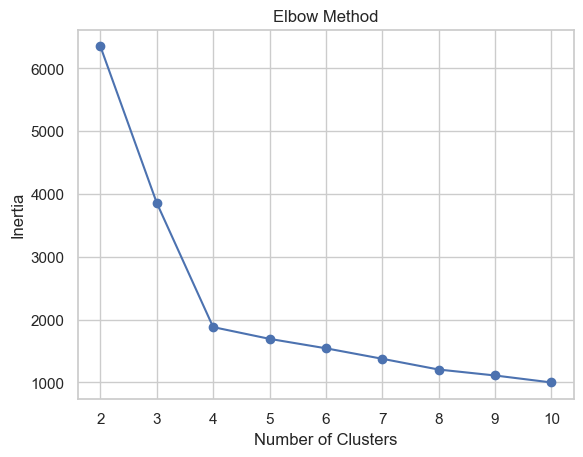

In [6]:
# Elbow Method
inertia = []
list_num_clusters = list(range(2, 11))
for num_clusters in list_num_clusters:
    km = Kmeans(num_clusters)
    km.predict(X, inertia=True)
    inertia.append(km.inertia)

plt.plot(list_num_clusters, inertia)
plt.scatter(list_num_clusters, inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

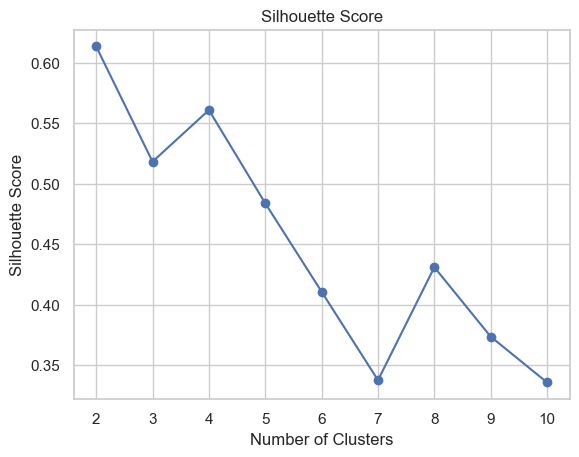

In [7]:
# Silhouette Score
silhouette_scores = []
list_num_clusters = list(range(2, 11))
for num_clusters in list_num_clusters:
    km = Kmeans(num_clusters)
    km.predict(X)
    score = silhouette_score(X, km.labels)
    silhouette_scores.append(score)

plt.plot(list_num_clusters, silhouette_scores)
plt.scatter(list_num_clusters, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

It is normal that the silhouette plot does not always perfectly match the elbow method plot. Each metric captures different aspects of clustering quality:

1. **Elbow method**: measures how compact the clusters are. It seeks to minimize the sum of the squared distances from each point to its nearest centroid. An "elbow" in the plot indicates the point where adding more clusters no longer significantly reduces the inertia.

2. **Silhouette index**: Evaluates how well separated a cluster is from the others. A high silhouette value indicates that the clusters are well defined and separated. The silhouette score may not be high if the clusters are close together or if there is overlap between them.

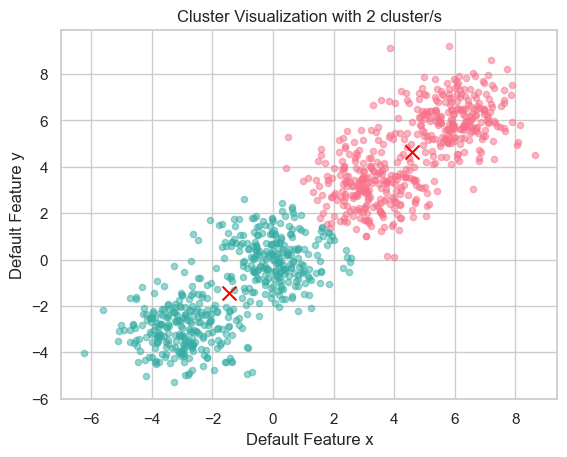

In [8]:
num_clusters = 2
km = Kmeans(k=num_clusters)
labels, centroids = km.predict(X)
display_cluster(X, km, num_clusters)

### Make Blobs Conclusion

In this case, the inertia metric and the silhouette score are giving different signals. We can choose the number of clusters based on the metric that best reflects the objective of the analysis:

- If we prefer well separated clusters, we can use the silhouette score and opt for 2 clusters.

- If we prefer more compact clusters, the elbow method and inertia suggest 4 clusters.

**In the end, the decision depends on the context of the analysis and the interpretation we want to make of the data.**

## Iris Plant Dataset Testing

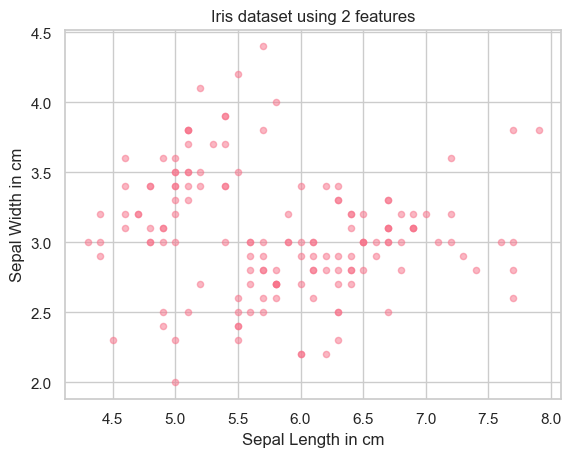

In [9]:
X = load_iris().data
display_cluster(
    X,
    title="Iris dataset using 2 features",
    feature_x="Sepal Length in cm",
    feature_y="Sepal Width in cm",
)

### Why is Standardizing Generally Better for K-means?

- **K-means is based on Euclidean distance**: In K-means, the algorithm minimizes the sum of the squared distances between the points and their respective centroids. If the features have very different scales, the distance will be dominated by the features with larger scale, which can lead to unrepresentative results. Standardizing helps to ensure that all features contribute equally to the calculated distances.

- **Similar dispersion between features**: Standardizing helps ensure that all features have similar dispersion, which ensures that one feature does not have excessive weight in the distance calculation.

In [10]:
X_standardized = StandardScaler().fit_transform(X)

Using a combination of features from different parts of the flower, like sepal width and petal length, can be useful in some contexts, particularly when investigating relationships between different categories. However, for K-means, which relies heavily on distance metrics, this mix can complicate the formation of distinct clusters, especially if the scales or variances of these features differ significantly.

In the Iris dataset, it’s generally observed that petal features offer a clearer separation between species, and standardizing these features can enhance cluster formation. Petal measurements, after standardization, tend to be more effective for K-means because the distances between points better reflect the actual differences between clusters.

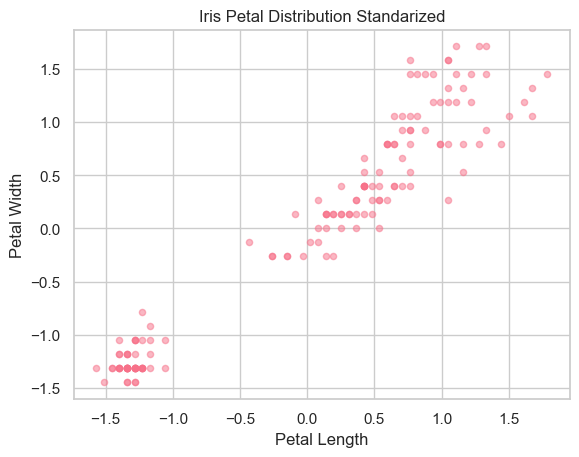

In [11]:
X_petal = X_standardized[:, [2, 3]]

display_cluster(
    X_petal,
    title="Iris Petal Distribution Standarized",
    feature_x="Petal Length",
    feature_y="Petal Width",
)

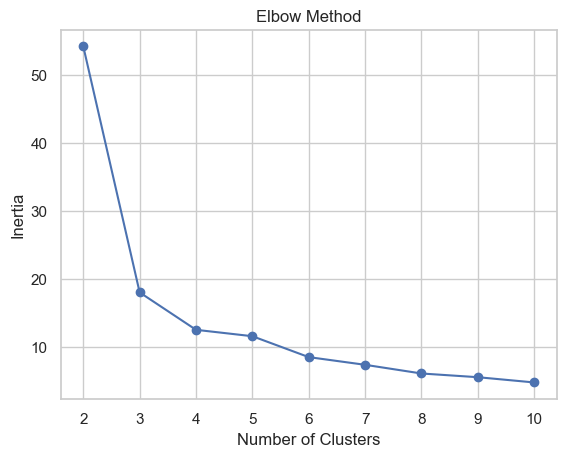

In [12]:
# Elbow Method
inertia = []
list_num_clusters = list(range(2, 11))
for num_clusters in list_num_clusters:
    km = Kmeans(num_clusters)
    km.predict(X_petal, inertia=True)
    inertia.append(km.inertia)

plt.plot(list_num_clusters, inertia)
plt.scatter(list_num_clusters, inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

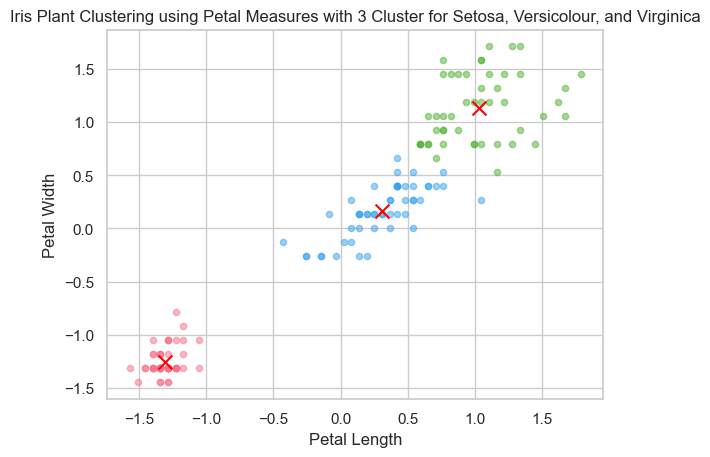

In [13]:
num_clusters = 3
km_iris = Kmeans(k=num_clusters)
labels, centroids = km_iris.predict(X_petal)

display_cluster(
    X_petal,
    km_iris,
    num_clusters,
    title="Iris Plant Clustering using Petal Measures with 3 Cluster for Setosa, Versicolour, and Virginica",
    feature_x="Petal Length",
    feature_y="Petal Width",
)